In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD, NMF
#from sklearn.pipeline import make_pipeline

# DecisionTreeClassifiers using entropy to maximize information gain 

In [19]:
df = pd.read_csv('/Users/jackboydell/Desktop/MATH 280/Financial_Sentiment_NLP.csv')
copy_df = df.copy()
print(df.info)
df.head(10)

<bound method DataFrame.info of                                                Sentence Sentiment
0     The GeoSolutions technology will leverage Bene...  positive
1     $ESI on lows, down $1.50 to $2.50 BK a real po...  negative
2     For the last quarter of 2010 , Componenta 's n...  positive
3     According to the Finnish-Russian Chamber of Co...   neutral
4     The Swedish buyout firm has sold its remaining...   neutral
...                                                 ...       ...
5837  RISING costs have forced packaging producer Hu...  negative
5838  Nordic Walking was first used as a summer trai...   neutral
5839  According shipping company Viking Line , the E...   neutral
5840  In the building and home improvement trade , s...   neutral
5841  HELSINKI AFX - KCI Konecranes said it has won ...  positive

[5842 rows x 2 columns]>


,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral
5,$SPY wouldn't be surprised to see a green close,positive
6,Shell's $70 Billion BG Deal Meets Shareholder ...,negative
7,SSH COMMUNICATIONS SECURITY CORP STOCK EXCHANG...,negative
8,Kone 's net sales rose by some 14 % year-on-ye...,positive
9,The Stockmann department store will have a tot...,neutral


(5842, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
Sentence     5842 non-null object
Sentiment    5842 non-null object
dtypes: object(2)
memory usage: 91.4+ KB
None


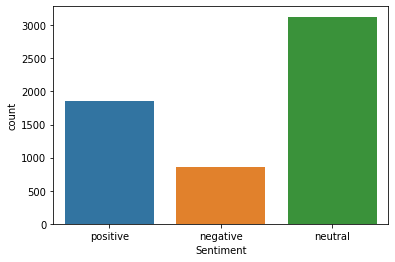

In [4]:
print(df.shape)
print(df.info())
sns.countplot(x='Sentiment', data=df)

In [5]:
encoding_values = {'positive':1, 'neutral':0, 'negative':-1}
df['Sentiment_encoded'] = df['Sentiment'].map(encoding_values)
df['Sentiment_encoded'] = df['Sentiment_encoded'].astype('category')

In [6]:
df = df.drop('Sentiment', axis = 1)
df.head()

,Sentence,Sentiment_encoded
0,The GeoSolutions technology will leverage Bene...,1
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",-1
2,"For the last quarter of 2010 , Componenta 's n...",1
3,According to the Finnish-Russian Chamber of Co...,0
4,The Swedish buyout firm has sold its remaining...,0


In [7]:
# creating three separate datasets based on sentiment encoded
positive, neutral, negative = df[df['Sentiment_encoded'] == 1], df[df['Sentiment_encoded'] == 0], df[df['Sentiment_encoded'] == -1]
df_lists = [negative, neutral, positive]

In [16]:
def model_pipeline(text_data):
    '''
    This function takes a column of text data entries and creates a Tfidf word frequency array for each.
    TruncatedSVD is performed to find the number of components to use in NMF analysis.
    '''
    tfidf_vec = TfidfVectorizer(stop_words = 'english')
    trunc_SVD = TruncatedSVD()
    
    X = tfidf_vec.fit_transform(text_data)
    print(type(X))
    tfidf_feature_names = tfidf_vec.get_feature_names()
    
    trunc_SVD.fit(X)
    sing_values = trunc_SVD.singular_values_
    
    n_components = len(trunc_SVD.components_)
    
    nmf = NMF(n_components = n_components, solver = 'mu', beta_loss = 'kullback-leibler')
    nmf.fit(X)
    
    return nmf, tfidf_feature_names, sing_values

In [17]:
def plot_top_words(model, feature_names, n_words, title):
    '''
    model(instance of sklearn model - NMF), feature_names(list of strings), n_words(int), title(str)
    '''
    fig, axes = plt.subplots(1,2)
    axes = axes.flatten()
    fig.suptitle(title)
    
    for topic_index, topic in enumerate(model.components_):
        top_features_ind = np.argsort(topic)[:-n_words-1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        
        ax = axes[topic_index]
        ax.barh(top_features, weights, height =0.7)
        ax.invert_yaxis()
        ax.set_title(f'Topic {topic_index + 1}')
        ax.set_xlabel('Weights')
    plt.subplots_adjust(wspace = 0.6) 
    plt.show()

<class 'scipy.sparse.csr.csr_matrix'>


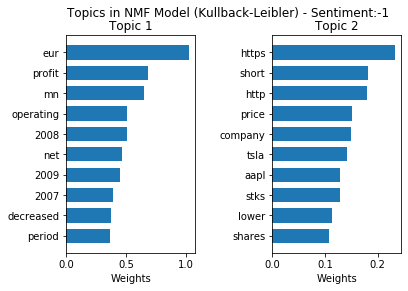

<class 'scipy.sparse.csr.csr_matrix'>


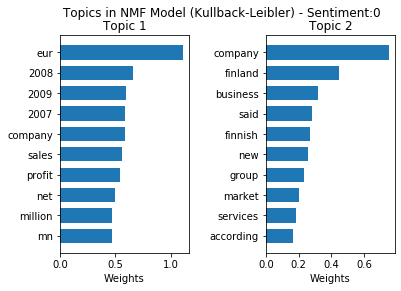

<class 'scipy.sparse.csr.csr_matrix'>


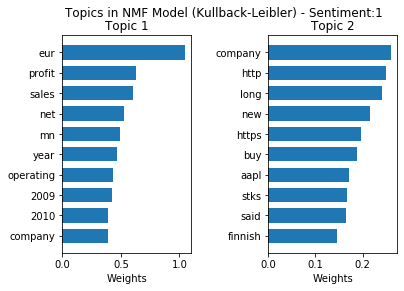

In [18]:
# graphing of the two topics for each of the sentiment subsets
for index, dataframe in enumerate(df_lists):
    title_name = index - 1
    model, tfidf_feature_names, sing_values = model_pipeline(dataframe['Sentence'])
    plot_top_words(model, tfidf_feature_names, 10, f'Topics in NMF Model (Kullback-Leibler) - Sentiment:{title_name}')